In [1]:
# import pandas as pd
# import random

# breeds_sizes = [
#     ("Labrador Retriever", "large"),
#     ("Golden Retriever", "large"),
#     ("German Shepherd", "large"),
#     ("Rottweiler", "large"),
#     ("Great Dane", "large"),
#     ("Doberman Pinscher", "large"),
#     ("Siberian Husky", "medium"),
#     ("Bulldog", "medium"),
#     ("Boxer", "medium"),
#     ("Australian Shepherd", "medium"),
#     ("Border Collie", "medium"),
#     ("Beagle", "small"),
#     ("Dachshund", "small"),
#     ("Poodle", "small"),
#     ("Chihuahua", "small"),
#     ("French Bulldog", "small"),
#     ("Yorkshire Terrier", "small"),
#     ("Shih Tzu", "small"),
#     ("Maltese", "small"),
#     ("Pomeranian", "small"),
#     ("French Griffon", "small")
# ]

# genders = ["Male", "Female"]

# num_rows = 2500

# username_list = random.sample(range(1000, 10000), num_rows)

# data = {
#     "username": [],
#     "pet_breed": [],
#     "age": [],
#     "size": [],
#     "gender": [],
#     "latitude": [],
#     "longitude": []
# }

# for i in range(num_rows):
#     # Pick a random breed-size pair
#     breed, size = random.choice(breeds_sizes)
    
#     # Random age between 1 and 15
#     age = random.randint(1, 15)
    
#     # Random gender
#     gender = random.choice(genders)
    
#     # Random geographic coordinates in Egypt
#     lat = random.uniform(22.0, 31.0)
#     lon = random.uniform(25.0, 36.0)
    
#     data["username"].append(username_list[i])
#     data["pet_breed"].append(breed)
#     data["age"].append(age)
#     data["size"].append(size)
#     data["gender"].append(gender)
#     data["latitude"].append(lat)
#     data["longitude"].append(lon)

# df = pd.DataFrame(data)

# df.to_csv("datasetTest2500.csv", index=False)

# # Show a small sample of the generated data
# print("A dataset with 5,000 rows (all located in Egypt) has been generated and saved to 'clean_pet_dataset_5000.csv'.")
# print(df.head(10))


In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# %matplotlib inline  # Uncomment if you'd like inline plots in Jupyter



In [3]:
# Replace 'petProfiles.csv' with your actual CSV file name/path
df = pd.read_csv('datasetTest2500.csv')

print("Initial DataFrame Head:")
print(df.head())

print("\nInitial DataFrame Info:")
print(df.info())


Initial DataFrame Head:
   username       pet_breed  age    size  gender   latitude  longitude
0      7831        Shih Tzu    9   small    Male  22.412832  30.484499
1      5344  Siberian Husky    3  medium    Male  28.011713  32.182210
2      1014  Siberian Husky    3  medium  Female  22.598486  34.320943
3      5584          Beagle   14   small  Female  30.139795  29.570332
4      8951  French Griffon    3   small  Female  25.102105  26.632985

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   username   2500 non-null   int64  
 1   pet_breed  2500 non-null   object 
 2   age        2500 non-null   int64  
 3   size       2500 non-null   object 
 4   gender     2500 non-null   object 
 5   latitude   2500 non-null   float64
 6   longitude  2500 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 136.8

In [4]:
# Identify your categorical columns (if they exist)
categorical_cols = []
if 'pet_breed' in df.columns:
    categorical_cols.append('pet_breed')
if 'size' in df.columns:
    categorical_cols.append('size')
if 'gender' in df.columns:
    categorical_cols.append('gender')

# One-hot encode these columns to avoid string-to-float issues
if len(categorical_cols) > 0:
    df = pd.get_dummies(df, columns=categorical_cols)

# Fill missing numeric columns if needed (example for 'age', 'latitude', 'longitude')
if 'age' in df.columns:
    df['age'].fillna(df['age'].mean(), inplace=True)
if 'latitude' in df.columns:
    df['latitude'].fillna(df['latitude'].mean(), inplace=True)
if 'longitude' in df.columns:
    df['longitude'].fillna(df['longitude'].mean(), inplace=True)

# Cast everything to float32
df = df.astype('float32')

print("\nAfter Encoding & Casting, DataFrame Info:")
print(df.info())



After Encoding & Casting, DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   username                       2500 non-null   float32
 1   age                            2500 non-null   float32
 2   latitude                       2500 non-null   float32
 3   longitude                      2500 non-null   float32
 4   pet_breed_Australian Shepherd  2500 non-null   float32
 5   pet_breed_Beagle               2500 non-null   float32
 6   pet_breed_Border Collie        2500 non-null   float32
 7   pet_breed_Boxer                2500 non-null   float32
 8   pet_breed_Bulldog              2500 non-null   float32
 9   pet_breed_Chihuahua            2500 non-null   float32
 10  pet_breed_Dachshund            2500 non-null   float32
 11  pet_breed_Doberman Pinscher    2500 non-null   float32
 12  pet_b

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Test set size:  {len(test_df)}")
print(test_df.head)


Train set size: 2000
Test set size:  500
<bound method NDFrame.head of       username   age   latitude  longitude  pet_breed_Australian Shepherd  \
1447    3886.0   8.0  28.656569  25.478121                            0.0   
1114    9442.0   2.0  29.298922  35.035732                            0.0   
1064    1084.0  15.0  30.879889  25.757378                            0.0   
2287    1841.0   9.0  22.917513  31.228300                            0.0   
1537    1211.0  10.0  26.001812  32.817219                            0.0   
...        ...   ...        ...        ...                            ...   
2375    9213.0   8.0  28.379662  34.371227                            0.0   
1609    6671.0  11.0  22.298546  28.568016                            0.0   
596     9414.0   1.0  28.861843  33.953133                            0.0   
84      1279.0  11.0  23.593615  25.459026                            0.0   
2213    1434.0   3.0  26.282795  34.582714                            0.0   

    

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute the Haversine distance in kilometers between two points specified in degrees.
    """
    R = 6371.0  # Earth radius in km
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    a = (math.sin(d_lat / 2)**2
         + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2))
         * math.sin(d_lon / 2)**2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


In [7]:
def create_pairs(df_subset, age_threshold=4.0, distance_threshold=50.0):
    """
    df_subset: DataFrame with numeric columns, including:
       breed_..., size_..., gender_..., age, latitude, longitude

    Returns: (pairs_array, labels_array)
      pairs_array shape: [num_pairs, 2, num_features]
      labels_array shape: [num_pairs,]

    Label=1 if:
      1) Opposite gender
      2) Haversine distance < distance_threshold
      3) |age1 - age2| <= age_threshold
      4) (same breed OR same size)
    Otherwise label=0.
    """
    data = df_subset.values  # shape: (num_rows, num_features)
    columns = list(df_subset.columns)

    # Identify columns
    breed_cols  = [c for c in columns if c.startswith('pet_breed_')]
    size_cols   = [c for c in columns if c.startswith('size_')]
    gender_cols = [c for c in columns if c.startswith('gender_')]

    lat_idx = columns.index('latitude')
    lon_idx = columns.index('longitude')
    age_idx = columns.index('age')

    # Convert col names to indices for breed, size, gender
    breed_indices  = [columns.index(c) for c in breed_cols]
    size_indices   = [columns.index(c) for c in size_cols]
    gender_indices = [columns.index(c) for c in gender_cols]

    def opposite_gender(vecA, vecB):
        # We assume columns like 'gender_Male', 'gender_Female'
        try:
            idx_male   = [i for i, c in enumerate(gender_cols) if 'Male'   in c][0]
            idx_female = [i for i, c in enumerate(gender_cols) if 'Female' in c][0]
        except IndexError:
            return False
        
        male_idx   = gender_indices[idx_male]
        female_idx = gender_indices[idx_female]

        A_is_male = (vecA[male_idx] > 0.5)
        A_is_fem  = (vecA[female_idx] > 0.5)
        B_is_male = (vecB[male_idx] > 0.5)
        B_is_fem  = (vecB[female_idx] > 0.5)

        return (A_is_male and B_is_fem) or (A_is_fem and B_is_male)

    def within_distance(vecA, vecB, km_thresh):
        lat1, lon1 = vecA[lat_idx], vecA[lon_idx]
        lat2, lon2 = vecB[lat_idx], vecB[lon_idx]
        dist_km = haversine_distance(lat1, lon1, lat2, lon2)
        return (dist_km <= km_thresh)

    def age_in_range(vecA, vecB, max_diff):
        return abs(vecA[age_idx] - vecB[age_idx]) <= max_diff

    pairs_list = []
    labels_list = []
    num_rows = data.shape[0]

    for i in range(num_rows - 1):
        for j in range(i + 1, num_rows):
            petA = data[i]
            petB = data[j]
            label = 0.0

            # Opposite gender
            if opposite_gender(petA, petB):
                # Within 50 km
                if within_distance(petA, petB, distance_threshold):
                    # Age difference <= 4 years
                    if age_in_range(petA, petB, age_threshold):
                        # Same breed OR same size
                        same_breed = False
                        for idx_b in breed_indices:
                            if (petA[idx_b] > 0.5) and (petB[idx_b] > 0.5):
                                same_breed = True
                                break
                        same_size = False
                        for idx_s in size_indices:
                            if (petA[idx_s] > 0.5) and (petB[idx_s] > 0.5):
                                same_size = True
                                break

                        if same_breed or same_size:
                            label = 1.0

            pairs_list.append([petA, petB])
            labels_list.append(label)

    pairs_array  = np.array(pairs_list,  dtype='float32')  
    labels_array = np.array(labels_list, dtype='float32')
    return pairs_array, labels_array



In [8]:
pairs_train, labels_train = create_pairs(train_df, age_threshold=4.0, distance_threshold=50.0)
pairs_test,  labels_test  = create_pairs(test_df,  age_threshold=4.0, distance_threshold=50.0)

print(f"Train pairs: {pairs_train.shape},  Train labels: {labels_train.shape}")
print(f"Test pairs:  {pairs_test.shape},   Test labels:  {labels_test.shape}")


Train pairs: (1999000, 2, 30),  Train labels: (1999000,)
Test pairs:  (124750, 2, 30),   Test labels:  (124750,)


In [9]:
# Separate pairs into (petA, petB) for training
pet_features_1_train = pairs_train[:, 0]
pet_features_2_train = pairs_train[:, 1]

# And for testing
pet_features_1_test  = pairs_test[:, 0]
pet_features_2_test  = pairs_test[:, 1]

def create_subnetwork(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)  # final embedding dimension
    return models.Model(inp, x)

# Build subnetwork
input_shape = (pet_features_1_train.shape[1],)
pet_network = create_subnetwork(input_shape)

# Siamese model
input_pet1 = Input(shape=input_shape, name='pet1_input')
input_pet2 = Input(shape=input_shape, name='pet2_input')

embedding_pet1 = pet_network(input_pet1)
embedding_pet2 = pet_network(input_pet2)

def euclidean_distance(vectors):
    petA, petB = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(petA - petB), axis=1, keepdims=True))

distance = layers.Lambda(euclidean_distance, name='distance')([embedding_pet1, embedding_pet2])
model = models.Model(inputs=[input_pet1, input_pet2], outputs=distance)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 pet1_input (InputLayer)     [(None, 30)]                 0         []                            
                                                                                                  
 pet2_input (InputLayer)     [(None, 30)]                 0         []                            
                                                                                                  
 model (Functional)          (None, 16)                   4592      ['pet1_input[0][0]',          
                                                                     'pet2_input[0][0]']          
                                                                                                  
 distance (Lambda)           (None, 1)                    0         ['model[0][0]',        

Epoch 1/10

49975/49975 [==============================] - 362s 7ms/step - loss: 8.1000 - val_loss: 5.9827
Epoch 2/10
49975/49975 [==============================] - 277s 6ms/step - loss: 2.6840 - val_loss: 0.5194
Epoch 3/10
49975/49975 [==============================] - 335s 7ms/step - loss: 1.5189 - val_loss: 0.0118
Epoch 4/10
49975/49975 [==============================] - 339s 7ms/step - loss: 1.0645 - val_loss: 0.6764
Epoch 5/10
49975/49975 [==============================] - 332s 7ms/step - loss: 0.6874 - val_loss: 0.9053
Epoch 6/10
49975/49975 [==============================] - 318s 6ms/step - loss: 0.5324 - val_loss: 0.3144
Epoch 7/10
49975/49975 [==============================] - 374s 7ms/step - loss: 0.3395 - val_loss: 0.0907
Epoch 8/10
49975/49975 [==============================] - 362s 7ms/step - loss: 0.3320 - val_loss: 0.4979
Epoch 9/10
49975/49975 [==============================] - 372s 7ms/step - loss: 0.7543 - val_loss: 1.3664
Epoch 10/10
49975/49975 [====================

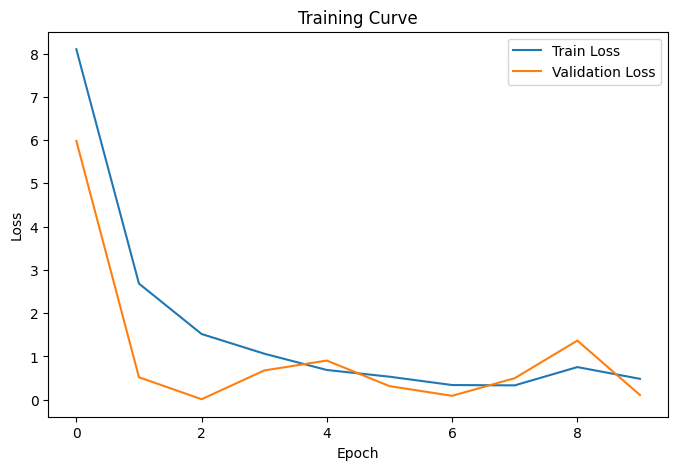

In [10]:
# def contrastive_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     margin = 1.0
#     return K.mean(
#         y_true * K.square(y_pred) +
#         (1 - y_true) * K.square(tf.maximum(margin - y_pred, 0))
#     )

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=contrastive_loss)

# history = model.fit(
#     [pet_features_1_train, pet_features_2_train],
#     labels_train,
#     epochs=5,
#     batch_size=32,
#     validation_split=0.2
# )

# plt.figure(figsize=(8,5))
# plt.plot(history.history['loss'], label='Train Loss')
# if 'val_loss' in history.history:
#     plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training Curve')
# plt.show()
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

def contrastive_loss(y_true, y_pred):
    # Ensure the ground truth labels are float32 (and assumed to be 0 or 1)
    y_true = tf.cast(y_true, tf.float32)
    margin = 1.0
    # Force the predictions to be non-negative (if they represent distances)
    y_pred = tf.abs(y_pred)
    # Compute contrastive loss
    loss = y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0.0))
    return tf.reduce_mean(loss)

# Use gradient clipping to limit the size of updates and improve stability.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer, loss=contrastive_loss)

history = model.fit(
    [pet_features_1_train, pet_features_2_train],
    labels_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.show()



In [11]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(
#     monitor='val_loss',     # Monitor the validation loss
#     patience=3,             # Number of epochs to wait after no improvement
#     restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
# )
# # Create a callback to save the model weights
# checkpoint_callback = ModelCheckpoint(
#     filepath='model_checkpoint.h5',   # Path to save the weights
#     save_weights_only=True,           # Only save weights (not the entire model)
#     save_best_only=True,              # Save only the best weights based on validation loss
#     monitor='val_loss',               # Monitor validation loss
#     verbose=1
# )

# # Load the previously saved weights
# model.load_weights('model_checkpoint.h5')

# # Resume training from the loaded weights
# history_resume = model.fit(
#     [pet_features_1_train, pet_features_2_train],
#     labels_train,
#     epochs=40,             # Continue training for additional epochs /# Set a high maximum number of epochs; training may stop early due to early stopping
#     batch_size=32,
#     validation_split= 0.2,
#     callbacks=[early_stop]
# )

# matches were not accurate after doing extra epochs i guess overfitting 


In [12]:
test_loss = model.evaluate([pet_features_1_test, pet_features_2_test], labels_test)
print("\nTest Loss:", test_loss)


3899/3899 [==============================] - 23s 6ms/step - loss: 0.1346

Test Loss: 0.13464249670505524


In [21]:
# # Suppose we want to embed all the test rows:
# test_data = test_df.values  # shape: (num_test_rows, num_features)
# all_test_embeddings = pet_network.predict(test_data)

# # Choose a query row (e.g., index 0)
# query_idx = 2
# query_vec = test_data[query_idx].reshape(1, -1)
# query_emb = pet_network.predict(query_vec)

# # Compute Euclidean distances
# distances = np.linalg.norm(all_test_embeddings - query_emb, axis=1)
# distances[query_idx] = np.inf  # so it won't match itself

# top_k = 5
# closest_idx = np.argsort(distances)[:top_k]
# print(f"Top {top_k} matches for test row #{query_idx}:", closest_idx)
# print("Distances:", distances[closest_idx])

# # If you kept an original reference DataFrame with textual data,
# # you could map these indices back to see the matched rows' info.



test_df = test_df.reset_index(drop=True)
test_data = test_df.values  # Now this will have indices from 0 to 499



# Specify the username you want to query
query_username = 9213  # Replace with the desired username

# Filter the DataFrame for the specific user
query_row = test_df[test_df['username'] == query_username]

if query_row.empty:
    print("Username not found!")
else:
    # Get the index of the query row from the DataFrame
    query_idx = query_row.index[0]
    
    # Compute the embeddings for all test rows
    test_data = test_df.values  # shape: (num_test_rows, num_features)
    all_test_embeddings = pet_network.predict(test_data)
    
    # Get the query vector and its embedding
    query_vec = test_data[query_idx].reshape(1, -1)
    query_emb = pet_network.predict(query_vec)
    
    # Compute Euclidean distances between the query and all test embeddings
    distances = np.linalg.norm(all_test_embeddings - query_emb, axis=1)
    distances[query_idx] = np.inf  # so it won't match itself
    
    # Find the top K closest matches
    top_k = 5
    closest_idx = np.argsort(distances)[:top_k]
    
    print(f"Top {top_k} matches for user '{query_username}' (DataFrame row #{query_idx}):", closest_idx)
    print("Distances:", distances[closest_idx])
    
    # Map the indices back to the original DataFrame to view details of matched rows
    closest_matches = test_df.iloc[closest_idx]
    print("\nMatched rows info:")
    print(closest_matches)


1/1 [==============================] - 0s 350ms/step
Top 5 matches for user '9213' (DataFrame row #495): [171 266 339 436 150]
Distances: [0.7049715  0.81342113 0.86124265 0.8712184  1.1644583 ]

Matched rows info:
     username   age   latitude  longitude  pet_breed_Australian Shepherd  \
171    9485.0  12.0  28.518875  30.254751                            0.0   
266    8885.0   5.0  26.809038  25.176567                            0.0   
339    8706.0   4.0  26.808348  25.138308                            0.0   
436    9659.0  12.0  28.474144  32.234341                            0.0   
150    9021.0   9.0  28.640509  34.837891                            0.0   

     pet_breed_Beagle  pet_breed_Border Collie  pet_breed_Boxer  \
171               0.0                      0.0              0.0   
266               0.0                      0.0              0.0   
339               0.0                      0.0              1.0   
436               0.0                      0.0              

In [25]:
# closest_matches = test_df.iloc[closest_idx]
# print(closest_matches)

print(test_df.to_string())



     username   age   latitude  longitude  pet_breed_Australian Shepherd  pet_breed_Beagle  pet_breed_Border Collie  pet_breed_Boxer  pet_breed_Bulldog  pet_breed_Chihuahua  pet_breed_Dachshund  pet_breed_Doberman Pinscher  pet_breed_French Bulldog  pet_breed_French Griffon  pet_breed_German Shepherd  pet_breed_Golden Retriever  pet_breed_Great Dane  pet_breed_Labrador Retriever  pet_breed_Maltese  pet_breed_Pomeranian  pet_breed_Poodle  pet_breed_Rottweiler  pet_breed_Shih Tzu  pet_breed_Siberian Husky  pet_breed_Yorkshire Terrier  size_large  size_medium  size_small  gender_Female  gender_Male
0      3886.0   8.0  28.656569  25.478121                            0.0               0.0                      0.0              0.0                0.0                  0.0                  0.0                          0.0                       0.0                       0.0                        0.0                         0.0                   0.0                           0.0                